# 1. Getting Started

Author: Arianna Basile, MRC Toxicology Unit, University of Cambridge

__________________________________________________________________________________________________________________
In this tutorial:
<ul>
    <li>You will use the library cobrapy to import a metabolic reconstruction (1.1) </li>
    <li>Inspect the reactions of your model (1.2)</li>
        <li>Inspect the metabolites in your model (1.3) </li>
        <li>Inspect the genes in your model (1.4) </li>
        <li>Perform in-silico gene knockout experiments (1.4.1) </li>
        <li>Do additional exercises</li>
        </ul>

In [28]:
#import the needed packages
import cobra

#enable autocompleting with tab
%config Completer.use_jedi = False


## 1.1 Import a reconstruction

The Systems Biology Markup Language is an XML-based standard format for distributing models which has support for COBRA models through the FBC extension version 2.

Cobrapy has native support for reading and writing SBML with FBCv2. Please note that all id’s in the model must conform to the SBML SID requirements in order to generate a valid SBML file.

Let's download and import the model of <a href="http://bigg.ucsd.edu/search?query=Saccharomyces+cerevisiae+S288C"> Saccharomyces cerevisiae </a>

In [29]:
model_yeast=cobra.io.read_sbml_model("iMM904.xml.gz")

The reactions, metabolites, and genes attributes of the cobrapy model are a special type of list called a cobra.DictList, and each one is made up of cobra.Reaction, cobra.Metabolite and cobra.Gene objects respectively.

In [30]:
print(len(model_yeast.reactions))
print(len(model_yeast.metabolites))
print(len(model_yeast.genes))

1577
1226
905


When using Jupyter notebook this type of information is rendered as a table.

In [31]:
model_yeast

Name,iMM904
Memory address,0x07fe928140a00
Number of metabolites,1226
Number of reactions,1577
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


Just like a regular list, objects in the DictList can be retrieved by index. For example, to get the 3rd reaction in the model (at index 2nd because of 0-indexing):

In [32]:
model_yeast.reactions[2]

Reaction identifier,13BGHe
Name,Exo 1 3 beta glucan glucohydrase
Memory address,0x07fe923576880
Stoichiometry,13BDglcn_e + h2o_e --> glc__D_e 1 3 beta D Glucan C6H10O5 + H2O H2O --> D-Glucose
GPR,YOR190W or YDR261C or YLR300W
Lower bound,0.0
Upper bound,999999.0


Additionally, items can be retrieved by their id using the DictList.get_by_id() function. For example, to get the cytosolic atp metabolite object (the id is “atp_c”), we will inspect metabolites in the section 1.3
For the moment, we can focus on the reactions of our model. 

## 1.2 Reactions

We will consider the reaction glucose 6-phosphate isomerase, which interconverts glucose 6-phosphate and fructose 6-phosphate. The reaction id for this reaction in our test model is PGI. However, if you want to see the iDs of all the reactions in the reconstruction, you can run the code below:

In [33]:
reaction_ids = [reaction.id for reaction in model_yeast.reactions]
reaction_ids

['CITtcp',
 '13BGH',
 '13BGHe',
 '13GS',
 '16GS',
 '23CAPPD',
 '2DDA7Ptm',
 '2DHPtm',
 '2DOXG6PP',
 '2HBO',
 '2HBt2',
 '2HMHMBQMTm',
 '2HP6MPMOm',
 '2HPMBQMTm',
 '2HPMMBQMOm',
 '2MBACt',
 'EX_epistest_SC_e',
 'EX_epist_e',
 '2MBALDt',
 '2MBALDtm',
 '2MBTOHt',
 'ACACT6p',
 '2MBTOHtm',
 'ACACT7p',
 '2MPPALt',
 'ACACT8p',
 'ACACT9p',
 'ACALDCD',
 'ACALDt',
 'ACALDtm',
 'ACCOAC',
 'ACCOACrm',
 'AGAT_SC',
 'AGPRim',
 'AGTi',
 'AHCYStm',
 'ACCOAtn',
 '2MPPALtm',
 'ACESt',
 'ACGAM6PS',
 'AHCi',
 'AHMMPS',
 'AHSERL',
 'AHSERL2',
 'ACGAMPM',
 'ACGKm',
 '2OBUTtm',
 'ACGSm',
 '2OXOADPtim',
 'ACHBSm',
 'ACHLE1',
 '2PHETOHt',
 'ACHLE2',
 'ACHLE3',
 'ACLSm',
 '2PHETOHtm',
 'ACOAHim',
 '34HPLFM',
 'ACOAO4p',
 'AICART',
 'AIRCr',
 'AKGDam',
 'AKGDbm',
 'ACOAO5p',
 'ACOAO6p',
 'ACOAO7p',
 'ACOAO8p',
 'ACOAO9p',
 'AKGMAL',
 'AKGt2n',
 'AKGt2r',
 '34HPPOR',
 'AKGtp',
 'AKP1',
 'ALASm',
 'ALATA_L',
 'ALATA_Lm',
 'ACOATA',
 'ACOATAm',
 'ACON3MT',
 'ALATRS',
 '34HPPt2m',
 'ALAt2r',
 'ALAtmi',
 'ACONT',
 'AC

Now, let's focus on PGI or another reaction of your choice:

In [34]:
pgi = model_yeast.reactions.get_by_id("PGI")
pgi

Reaction identifier,PGI
Name,Glucose-6-phosphate isomerase
Memory address,0x07fe923cbad00
Stoichiometry,g6p_c <=> f6p_c D-Glucose 6-phosphate <=> D-Fructose 6-phosphate
GPR,YBR196C
Lower bound,-999999.0
Upper bound,999999.0


We can view the full name and reaction catalyzed as strings.

In [35]:
print(pgi.name)
print(pgi.reaction)

Glucose-6-phosphate isomerase
g6p_c <=> f6p_c


We can also view reaction upper and lower bounds, large numbers, typically around 1000 or more, are used as infinite limits (unconstained fluxes). 
Because the pgi.lower_bound < 0, and pgi.upper_bound > 0, pgi is reversible.

In [36]:
print(pgi.lower_bound, "< pgi <", pgi.upper_bound)
print(pgi.reversibility)

-999999.0 < pgi < 999999.0
True


The lower and upper bound of reactions can also be modified, and the reversibility attribute will automatically be updated. The preferred method for manipulating bounds is using reaction.bounds, e.g.

In [37]:
old_bounds = pgi.bounds
pgi.bounds = (0, 1000.0)
print(pgi.lower_bound, "< pgi <", pgi.upper_bound)
print("Reversibility after modification:", pgi.reversibility)
pgi.bounds = old_bounds
print("Reversibility after resetting:", pgi.reversibility)

0 < pgi < 1000.0
Reversibility after modification: False
Reversibility after resetting: True


We can also ensure the reaction is mass balanced. This function will return elements which violate mass balance. If it comes back empty, then the reaction is mass balanced.

In [38]:
pgi.check_mass_balance()

{}

In order to add a metabolite, we pass in a dictionary with the metabolite object and its coefficient

In [39]:
pgi.add_metabolites({model_yeast.metabolites.get_by_id("h_c"): -1})
pgi.reaction

'g6p_c + h_c <=> f6p_c'

The reaction is no longer mass balanced

In [40]:
pgi.check_mass_balance()

{'charge': -1.0, 'H': -1.0}

We can remove the metabolite, and the reaction will be balanced once again.



In [41]:
pgi.subtract_metabolites({model_yeast.metabolites.get_by_id("h_c"): -1})
print(pgi.reaction)
print(pgi.check_mass_balance())

g6p_c <=> f6p_c
{}


## 1.3 Metabolites

We will consider cytosolic atp as our metabolite, which has the id "atp_c" in our test model. However, if you want to see the iDs of all the metabolites in the reconstruction, you can run the code below:

In [42]:
metabolite_ids = [metabolite.id for metabolite in model_yeast.metabolites]
metabolite_ids

['2dr5p_c',
 '2hb_c',
 '2hb_e',
 '2hhxdal_c',
 '2hp6mbq_m',
 '2hp6mp_m',
 '2hpmhmbq_m',
 '2hpmmbq_m',
 '2ippm_c',
 '2kmb_c',
 '2mahmp_c',
 '2mbac_c',
 '2mbac_e',
 '2mbald_c',
 '2mbald_e',
 '2mbald_m',
 '2mbtoh_c',
 '2mbtoh_e',
 '2mbtoh_m',
 '2mcit_m',
 '2mppal_c',
 '2mppal_e',
 '2mppal_m',
 '2obut_c',
 '2obut_m',
 '2oxoadp_c',
 '2oxoadp_m',
 '2pg_c',
 '2phetoh_c',
 '2phetoh_e',
 '2phetoh_m',
 '10fthf_c',
 '34hpl_m',
 '34hpp_c',
 '34hpp_m',
 '10fthf_m',
 '4fumacac_c',
 '34hpp_x',
 '35ccmp_c',
 '4gudbd_c',
 '12dgr_SC_c',
 '35cdamp_c',
 '13BDglcn_c',
 '4gudbutn_c',
 '35cgmp_c',
 '4h2oglt_c',
 '13BDglcn_e',
 '35cimp_c',
 '13dampp_c',
 '13dpg_c',
 '4h2oglt_m',
 '4h2oglt_x',
 '3c2hmp_c',
 '14glun_c',
 '3c3hmp_c',
 '16BDglcn_c',
 '3c3hmp_e',
 '1Dgali_c',
 '4hbz_c',
 '3c3hmp_m',
 '4hbz_m',
 '1ag3p_SC_c',
 '4hbzcoa_m',
 '3c4mop_c',
 '4hglusa_m',
 '1agly3p_SC_c',
 '1agpc_SC_c',
 '3c4mop_m',
 '1mncam_c',
 '4hpro_LT_c',
 '3dh5hpb_c',
 '4hpro_LT_m',
 '1p3h5c_c',
 '3dh5hpb_m',
 '1p3h5c_m',
 '4hthr_c

Now, let's focus on atp_c or another metabolite of your choice:

In [43]:
atp = model_yeast.metabolites.get_by_id("atp_c")
atp

Metabolite identifier,atp_c
Name,ATP C10H12N5O13P3
Memory address,0x07fe922979700
Formula,C10H12N5O13P3
Compartment,c
In 149 reaction(s),"DBTS, ATPM, ASPTRS, FTHFLi, DGK1, GLUTRS, RBK, PYK, DHFS, ATP2tp_H, GMPS2, PFK_2, LYSTRS, PAK_SC, DPCOAK, AASAD2, CYSTRS, TMDK1, PFK26, PC, GLNS, NDPK1, NNATr, HETZK, PFK, PMEVK, PMPK, URIK1,..."


We can print out the metabolite name and compartment (cytosol in this case) directly as string.



In [44]:
print(atp.name)
print(atp.compartment)

ATP C10H12N5O13P3
c


We can see that ATP is a charged molecule in our model.



In [45]:
atp.charge

-4

We can see the chemical formula for the metabolite as well.



In [46]:
print(atp.formula)

C10H12N5O13P3


## 1.4 Genes

The gene_reaction_rule is a boolean representation of the gene requirements for this reaction to be active as described in <a href="https://www.nature.com/articles/nprot.2011.308">Schellenberger et al 2011 Nature Protocols 6(9):1290-307</a>.

The GPR is stored as the GPR class in the gpr for a Reaction. A string representation of it is stored as the gene_reaction_rule for a Reaction object.

In [47]:
gpr_string = pgi.gene_reaction_rule
print(gpr_string)

YBR196C


Corresponding gene objects also exist. These objects are tracked by the reactions itself, as well as by the model

In [48]:
pgi_gene = model_yeast.genes.get_by_id("YBR196C")
pgi_gene

Gene identifier,YBR196C
Name,PGI1
Memory address,0x07fe9234edc40
Functional,True
In 3 reaction(s),"PGI, G6PI3, G6PI"


Let's check this gene also on KEGG database to assess the consistency of the metabolic reconstruction --> <a href="https://www.genome.jp/entry/sce:YBR196C"> HERE </a> 

### 1.4.1 Simulating Knockouts

The delete_model_genes function will evaluate the GPR and set the upper and lower bounds to 0 if the reaction is knocked out.

In [59]:
model_yeast=cobra.io.read_sbml_model("iMM904.xml.gz")
pgi=model_yeast.reactions.get_by_id("PGI")
print("before KO: %4d < flux_PGI < %4d" % (pgi.lower_bound, pgi.upper_bound))


gene=model_yeast.genes.get_by_id("YBR196C")
gene.knock_out()
print("after KO: %4d < flux_PGI < %4d" % (pgi.lower_bound, pgi.upper_bound))


before KO: -999999 < flux_PGI < 999999
after KO:    0 < flux_PGI <    0


Quite often, one wants to make small changes to a model and evaluate the impacts of these. For example, we may want to knock-out all reactions sequentially, and see what the impact of this is on the objective function. One way of doing this would be to create a new copy of the model before each knock-out with model.copy(). However, even with small models, this is a very slow approach as models are quite complex objects. Better then would be to do the knock-out, optimizing and then manually resetting the reaction bounds before proceeding with the next reaction. Since this is such a common scenario however, cobrapy allows us to use the model as a context, to have changes reverted automatically.

In [61]:
#we import the model again to reverse the previous edits
model_yeast=cobra.io.read_sbml_model("iMM904.xml.gz")

#we simulate knockouts of single reactions 
model_yeast.optimize()
print(model_yeast.objective.value)
for reaction in model_yeast.reactions:
    with model_yeast as model_yeast:  #not to edit the original model
        reaction.knock_out()
        model_yeast.optimize()
        print('%s blocked (bounds: %s), new growth rate %f' %
              (reaction.id, str(reaction.bounds), model_yeast.objective.value))

0.28786570370401665
CITtcp blocked (bounds: (0, 0)), new growth rate 0.287866
13BGH blocked (bounds: (0, 0)), new growth rate 0.287866
13BGHe blocked (bounds: (0, 0)), new growth rate 0.287866
13GS blocked (bounds: (0, 0)), new growth rate 0.000000
16GS blocked (bounds: (0, 0)), new growth rate 0.287866
23CAPPD blocked (bounds: (0, 0)), new growth rate 0.287866
2DDA7Ptm blocked (bounds: (0, 0)), new growth rate 0.287866
2DHPtm blocked (bounds: (0, 0)), new growth rate 0.287866
2DOXG6PP blocked (bounds: (0, 0)), new growth rate 0.287866
2HBO blocked (bounds: (0, 0)), new growth rate 0.287866
2HBt2 blocked (bounds: (0, 0)), new growth rate 0.287866
2HMHMBQMTm blocked (bounds: (0, 0)), new growth rate 0.287866
2HP6MPMOm blocked (bounds: (0, 0)), new growth rate 0.287866
2HPMBQMTm blocked (bounds: (0, 0)), new growth rate 0.287866
2HPMMBQMOm blocked (bounds: (0, 0)), new growth rate 0.287866
2MBACt blocked (bounds: (0, 0)), new growth rate 0.287866
EX_epistest_SC_e blocked (bounds: (0, 0))

ALLTN blocked (bounds: (0, 0)), new growth rate 0.287866
ALLTNti blocked (bounds: (0, 0)), new growth rate 0.287866
ALLTTti blocked (bounds: (0, 0)), new growth rate 0.287866
ADNt2 blocked (bounds: (0, 0)), new growth rate 0.287866
3C4MOPtm blocked (bounds: (0, 0)), new growth rate 0.287866
ADPT blocked (bounds: (0, 0)), new growth rate 0.287866
ADSK blocked (bounds: (0, 0)), new growth rate 0.000000
ALPHNH blocked (bounds: (0, 0)), new growth rate 0.287866
AMAOTr blocked (bounds: (0, 0)), new growth rate 0.287866
ADSL1r blocked (bounds: (0, 0)), new growth rate 0.000000
AMETt2 blocked (bounds: (0, 0)), new growth rate 0.287866
3DH5HPBMTm blocked (bounds: (0, 0)), new growth rate 0.287866
AMETtm blocked (bounds: (0, 0)), new growth rate 0.287866
AMID blocked (bounds: (0, 0)), new growth rate 0.287866
AMID2 blocked (bounds: (0, 0)), new growth rate 0.287866
AMID3 blocked (bounds: (0, 0)), new growth rate 0.287866
ADSL2r blocked (bounds: (0, 0)), new growth rate 0.000000
ADSS blocked (bo

CHLPCTD blocked (bounds: (0, 0)), new growth rate 0.287866
CHLSTI blocked (bounds: (0, 0)), new growth rate 0.287859
CLPNSm_SC blocked (bounds: (0, 0)), new growth rate 0.287866
3OPHB5Hm blocked (bounds: (0, 0)), new growth rate 0.287866
CMPN blocked (bounds: (0, 0)), new growth rate 0.287866
CHLt2 blocked (bounds: (0, 0)), new growth rate 0.287866
CHOLK blocked (bounds: (0, 0)), new growth rate 0.287866
CHORM blocked (bounds: (0, 0)), new growth rate 0.000000
CHORS blocked (bounds: (0, 0)), new growth rate 0.000000
CHRPL blocked (bounds: (0, 0)), new growth rate 0.287866
CO2t blocked (bounds: (0, 0)), new growth rate 0.218775
CO2tg blocked (bounds: (0, 0)), new growth rate 0.287866
CO2tm blocked (bounds: (0, 0)), new growth rate 0.000000
CO2tn blocked (bounds: (0, 0)), new growth rate 0.287866
CO2tp blocked (bounds: (0, 0)), new growth rate 0.287866
CHTNDA blocked (bounds: (0, 0)), new growth rate 0.287866
CHTNS blocked (bounds: (0, 0)), new growth rate 0.287866
CITt2r blocked (bounds

EPMGH blocked (bounds: (0, 0)), new growth rate 0.287866
4MOPDC blocked (bounds: (0, 0)), new growth rate 0.287866
ERGSTAT_SC blocked (bounds: (0, 0)), new growth rate 0.287866
ERGSTESTH_SC blocked (bounds: (0, 0)), new growth rate 0.287866
ERGSTESTH_SCe blocked (bounds: (0, 0)), new growth rate 0.287866
ERGSTGLCT blocked (bounds: (0, 0)), new growth rate 0.287866
D_LACDm blocked (bounds: (0, 0)), new growth rate 0.287866
D_LACt2 blocked (bounds: (0, 0)), new growth rate 0.287866
D_LACt2m blocked (bounds: (0, 0)), new growth rate 0.287866
D_LACtm blocked (bounds: (0, 0)), new growth rate 0.287866
E4HGLUtm blocked (bounds: (0, 0)), new growth rate 0.287866
ERGSTt blocked (bounds: (0, 0)), new growth rate 0.287866
ERGSTter blocked (bounds: (0, 0)), new growth rate 0.000000
ERGTETROLter blocked (bounds: (0, 0)), new growth rate 0.000000
E4HGLUtp blocked (bounds: (0, 0)), new growth rate 0.287866
E4Ptm blocked (bounds: (0, 0)), new growth rate 0.287866
ETHAK blocked (bounds: (0, 0)), new g

/Users/arianna/miniconda3/envs/carveme2/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


EX_glu__L_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_glx_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_ade_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_adn_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_akg_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_ala__L_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_gly_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_glyc_e blocked (bounds: (0, 0)), new growth rate 0.287866
AACTOOR blocked (bounds: (0, 0)), new growth rate 0.287866
EX_gsn_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_gthox_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_gthrd_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_alltn_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_alltt_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_amet_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_arab__D_e blocked (bounds: (0, 0)), new growth rate 0.287866
EX_arab__L_e blocked 

FA140ACPHi blocked (bounds: (0, 0)), new growth rate 0.287866
FACOAL180 blocked (bounds: (0, 0)), new growth rate 0.287866
FACOAL181 blocked (bounds: (0, 0)), new growth rate 0.287866
FACOAL182 blocked (bounds: (0, 0)), new growth rate 0.287866
FA140ACPtm blocked (bounds: (0, 0)), new growth rate 0.287866
FACOAL240p blocked (bounds: (0, 0)), new growth rate 0.287866
FA140COAabcp blocked (bounds: (0, 0)), new growth rate 0.287866
FA140tp blocked (bounds: (0, 0)), new growth rate 0.287866
FA141ACPHi blocked (bounds: (0, 0)), new growth rate 0.287866
FA141ACPtm blocked (bounds: (0, 0)), new growth rate 0.287866
FACOAL260p blocked (bounds: (0, 0)), new growth rate 0.287866
FACOAL80p blocked (bounds: (0, 0)), new growth rate 0.287866
FADFMNtm blocked (bounds: (0, 0)), new growth rate 0.287866
FALDH blocked (bounds: (0, 0)), new growth rate 0.287866
FA141COAabcp blocked (bounds: (0, 0)), new growth rate 0.287866
FAS161ACPm blocked (bounds: (0, 0)), new growth rate 0.287866
FA141tp blocked (b

GDPtn blocked (bounds: (0, 0)), new growth rate 0.287866
GF6PTA blocked (bounds: (0, 0)), new growth rate 0.287866
GPDDA1 blocked (bounds: (0, 0)), new growth rate 0.287866
GGLGH blocked (bounds: (0, 0)), new growth rate 0.287866
FBA blocked (bounds: (0, 0)), new growth rate 0.287866
GGTT blocked (bounds: (0, 0)), new growth rate 0.287866
GHMT2r blocked (bounds: (0, 0)), new growth rate 0.279848
GHMT2rm blocked (bounds: (0, 0)), new growth rate 0.287866
GRTT blocked (bounds: (0, 0)), new growth rate 0.000000
GSNK blocked (bounds: (0, 0)), new growth rate 0.287866
GSNt2 blocked (bounds: (0, 0)), new growth rate 0.287866
GK1 blocked (bounds: (0, 0)), new growth rate 0.287866
GK2 blocked (bounds: (0, 0)), new growth rate 0.287866
GLCGSD blocked (bounds: (0, 0)), new growth rate 0.287866
GLCGSDv blocked (bounds: (0, 0)), new growth rate 0.287866
GSNt2m blocked (bounds: (0, 0)), new growth rate 0.287866
GTHOr blocked (bounds: (0, 0)), new growth rate 0.287866
GTHOXti blocked (bounds: (0, 0)

/Users/arianna/miniconda3/envs/carveme2/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


GTPCI blocked (bounds: (0, 0)), new growth rate 0.287866
GTPCII blocked (bounds: (0, 0)), new growth rate 0.000000
GTPH1 blocked (bounds: (0, 0)), new growth rate 0.287866
GLNt7 blocked (bounds: (0, 0)), new growth rate 0.287866
GTPt2m blocked (bounds: (0, 0)), new growth rate 0.287866
GLPT blocked (bounds: (0, 0)), new growth rate 0.287866
FBP26 blocked (bounds: (0, 0)), new growth rate 0.287866
GLU5K blocked (bounds: (0, 0)), new growth rate 0.287809
GLUCYS blocked (bounds: (0, 0)), new growth rate 0.287866
GLUDC blocked (bounds: (0, 0)), new growth rate 0.287866
GUAD blocked (bounds: (0, 0)), new growth rate 0.287866
GUAPRT blocked (bounds: (0, 0)), new growth rate 0.287866
GUAt2r blocked (bounds: (0, 0)), new growth rate 0.287866
GUAtm blocked (bounds: (0, 0)), new growth rate 0.287866
H2O2tn blocked (bounds: (0, 0)), new growth rate 0.287866
H2Ot blocked (bounds: (0, 0)), new growth rate 0.143803
GLUDxi blocked (bounds: (0, 0)), new growth rate 0.287866
GLUDy blocked (bounds: (0, 

ICL blocked (bounds: (0, 0)), new growth rate 0.287510
LANOSTESTH_SC blocked (bounds: (0, 0)), new growth rate 0.287866
FOLD3m blocked (bounds: (0, 0)), new growth rate 0.287866
LANOSTESTH_SCe blocked (bounds: (0, 0)), new growth rate 0.287866
LANOSTt blocked (bounds: (0, 0)), new growth rate 0.287866
LCADi blocked (bounds: (0, 0)), new growth rate 0.287866
LCYSTintv blocked (bounds: (0, 0)), new growth rate 0.287866
LEUTA blocked (bounds: (0, 0)), new growth rate 0.000000
LEUTAm blocked (bounds: (0, 0)), new growth rate 0.287866
LEUTRS blocked (bounds: (0, 0)), new growth rate 0.287866
LEUTRSm blocked (bounds: (0, 0)), new growth rate 0.287866
ID3ACALDt blocked (bounds: (0, 0)), new growth rate 0.287866
ID3ACALDtm blocked (bounds: (0, 0)), new growth rate 0.287866
IG3PS blocked (bounds: (0, 0)), new growth rate 0.000000
IGPDH blocked (bounds: (0, 0)), new growth rate 0.000000
IGPS blocked (bounds: (0, 0)), new growth rate 0.000000
ILETA blocked (bounds: (0, 0)), new growth rate 0.2878

MIP2CS224_SC blocked (bounds: (0, 0)), new growth rate 0.287866
FUMm blocked (bounds: (0, 0)), new growth rate 0.287247
MIP2CS226_SC blocked (bounds: (0, 0)), new growth rate 0.287866
MIP2CS324_SC blocked (bounds: (0, 0)), new growth rate 0.287866
MIP2CS326_SC blocked (bounds: (0, 0)), new growth rate 0.287866
MIPC124PLC_SC blocked (bounds: (0, 0)), new growth rate 0.287866
NDPK1 blocked (bounds: (0, 0)), new growth rate 0.287866
NDPK2 blocked (bounds: (0, 0)), new growth rate 0.000000
NDPK3 blocked (bounds: (0, 0)), new growth rate 0.287757
NDPK4 blocked (bounds: (0, 0)), new growth rate 0.287866
NDPK5 blocked (bounds: (0, 0)), new growth rate 0.287866
MIPC126PLC_SC blocked (bounds: (0, 0)), new growth rate 0.287866
NDPK6 blocked (bounds: (0, 0)), new growth rate 0.287866
FUMt2r blocked (bounds: (0, 0)), new growth rate 0.287866
NDPK7 blocked (bounds: (0, 0)), new growth rate 0.287866
NDPK8 blocked (bounds: (0, 0)), new growth rate 0.287866
MIPC224PLC_SC blocked (bounds: (0, 0)), new 

PCDAGAT blocked (bounds: (0, 0)), new growth rate 0.287866
PIt5m blocked (bounds: (0, 0)), new growth rate 0.287866
PLBP1I_SCe blocked (bounds: (0, 0)), new growth rate 0.287866
PLBPC_SC blocked (bounds: (0, 0)), new growth rate 0.287866
PDE1 blocked (bounds: (0, 0)), new growth rate 0.287866
PLBPC_SCe blocked (bounds: (0, 0)), new growth rate 0.287866
PPPGOm blocked (bounds: (0, 0)), new growth rate 0.287866
PLD_SC blocked (bounds: (0, 0)), new growth rate 0.287866
PMANM blocked (bounds: (0, 0)), new growth rate 0.000000
PMDPHT blocked (bounds: (0, 0)), new growth rate 0.000000
PMETM_SC blocked (bounds: (0, 0)), new growth rate 0.000000
PDE2 blocked (bounds: (0, 0)), new growth rate 0.287866
PDE3 blocked (bounds: (0, 0)), new growth rate 0.287866
PDE4 blocked (bounds: (0, 0)), new growth rate 0.287866
PDE5 blocked (bounds: (0, 0)), new growth rate 0.287866
GCC2cm_copy2 blocked (bounds: (0, 0)), new growth rate 0.287866
PDHm blocked (bounds: (0, 0)), new growth rate 0.281522
PDX5POi bl

THMPPt2m blocked (bounds: (0, 0)), new growth rate 0.287866
THMPe blocked (bounds: (0, 0)), new growth rate 0.287866
THRt2r blocked (bounds: (0, 0)), new growth rate 0.287866
THYMt3r blocked (bounds: (0, 0)), new growth rate 0.287866
THZPSN1_SC blocked (bounds: (0, 0)), new growth rate 0.287866
THZPSN2_SC blocked (bounds: (0, 0)), new growth rate 0.287866
THMt2 blocked (bounds: (0, 0)), new growth rate 0.287866
PSERDg_SC blocked (bounds: (0, 0)), new growth rate 0.287866
THRA2 blocked (bounds: (0, 0)), new growth rate 0.287866
TKT1 blocked (bounds: (0, 0)), new growth rate 0.285794
PSERDm_SC blocked (bounds: (0, 0)), new growth rate 0.287749
TKT2 blocked (bounds: (0, 0)), new growth rate 0.287021
TMDK1 blocked (bounds: (0, 0)), new growth rate 0.287866
TMDPK blocked (bounds: (0, 0)), new growth rate 0.287866
THRA blocked (bounds: (0, 0)), new growth rate 0.287866
THRD_L blocked (bounds: (0, 0)), new growth rate 0.287707
THRD_Lm blocked (bounds: (0, 0)), new growth rate 0.287866
THRS bl

In [62]:
#we import the model again to reverse the previous edits
model_yeast=cobra.io.read_sbml_model("iMM904.xml.gz")

#we simulate gene knockouts directly, this time we are storing the results in a vector and plotting it
genes_ids=[gene.id for gene in model_yeast.genes]
grow_rates=[]

model_yeast.optimize()
print(model_yeast.objective.value)
for gene in model_yeast.genes:
    with model_yeast as model_yeast:  #not to edit the original model
        gene.knock_out()
        model_yeast.optimize()
        grow_rates.append(model_yeast.objective.value)
        print('%s, new growth rate %f' %
              (gene.id, model_yeast.objective.value))

0.28786570370401665
YHR104W, new growth rate 0.287866
YDR368W, new growth rate 0.287866
YGR282C, new growth rate 0.287866
YOL086C, new growth rate 0.287866
YLR300W, new growth rate 0.287866
YFR055W, new growth rate 0.287866
YGL184C, new growth rate 0.287866
YDR261C, new growth rate 0.287866
YDL168W, new growth rate 0.287866
YOR190W, new growth rate 0.287866
YOL030W, new growth rate 0.287866
YLR343W, new growth rate 0.287866
YNL247W, new growth rate 0.287866
YMR303C, new growth rate 0.287866
YGR155W, new growth rate 0.287843
YGR032W, new growth rate 0.287866
YOL132W, new growth rate 0.287866
YGL256W, new growth rate 0.287866
YBR145W, new growth rate 0.287866
YCR034W, new growth rate 0.000000
YMR215W, new growth rate 0.287866
YMR307W, new growth rate 0.287866
YLR342W, new growth rate 0.287866
YMR306W, new growth rate 0.287866
YBR068C, new growth rate 0.287866
YMR083W, new growth rate 0.287866
YMR318C, new growth rate 0.287866
YBR036C, new growth rate 0.287866
YDR046C, new growth rate 0.2

YER056C, new growth rate 0.287866
YBL030C, new growth rate 0.287866
YER060W, new growth rate 0.287866
YGL186C, new growth rate 0.287866
YDL141W, new growth rate 0.287866
YKL140W, new growth rate 0.287866
YOL064C, new growth rate 0.285150
YLL012W, new growth rate 0.287866
YIL124W, new growth rate 0.287866
YAL060W, new growth rate 0.287866
YDR226W, new growth rate 0.000000
YLR020C, new growth rate 0.287866
YGR065C, new growth rate 0.287866
YIL013C, new growth rate 0.287866
YER170W, new growth rate 0.287866
YGR286C, new growth rate 0.287866
YNL280C, new growth rate 0.000000
YOL052C, new growth rate 0.287866
YOR011W, new growth rate 0.287866
YHR042W, new growth rate 0.000000
YBR184W, new growth rate 0.287866
YJL005W, new growth rate 0.287866
YMR015C, new growth rate 0.287866
YNL111C, new growth rate 0.287858
YJR105W, new growth rate 0.287802
YNR019W, new growth rate 0.287866
YKL150W, new growth rate 0.287866
YIL043C, new growth rate 0.287866
YLR189C, new growth rate 0.287866
YDR400W, new g

YBR221C, new growth rate 0.281522
YLR081W, new growth rate 0.287866
YDR234W, new growth rate 0.000000
YER178W, new growth rate 0.281522
YNR041C, new growth rate 0.287866
YBR035C, new growth rate 0.287866
YDL182W, new growth rate 0.287866
YNL318C, new growth rate 0.287866
YGR147C, new growth rate 0.287866
YDL040C, new growth rate 0.287866
YGR192C, new growth rate 0.287866
YDL131W, new growth rate 0.287866
YKR093W, new growth rate 0.287866
YPL273W, new growth rate 0.287866
YJL052W, new growth rate 0.287866
YGR007W, new growth rate 0.287866
YJR009C, new growth rate 0.287866
YLL062C, new growth rate 0.287866
YGR157W, new growth rate 0.000000
YMR205C, new growth rate 0.071791
YER141W, new growth rate 0.287866
YDR408C, new growth rate 0.000000
YGR240C, new growth rate 0.071791
YKR067W, new growth rate 0.287866
YBL011W, new growth rate 0.287866
YDR376W, new growth rate 0.287866
YIL107C, new growth rate 0.287866
YPL252C, new growth rate 0.287866
YOL136C, new growth rate 0.287866
YEL011W, new g

YNL117W, new growth rate 0.287866
YIR031C, new growth rate 0.287866
YOL143C, new growth rate 0.000000
YJL216C, new growth rate 0.287866
YBR299W, new growth rate 0.287866
YFL001W, new growth rate 0.287866
YBR256C, new growth rate 0.000000
YGR287C, new growth rate 0.287866
YIL066C, new growth rate 0.287866
YGR292W, new growth rate 0.287866
YNL292W, new growth rate 0.287866
YER060W_A, new growth rate 0.287866
YER070W, new growth rate 0.287866
YJL026W, new growth rate 0.287866
YEL017C_A, new growth rate 0.287866
YIL172C, new growth rate 0.287866
YGR180C, new growth rate 0.287866
YGR289C, new growth rate 0.287866
YNL129W, new growth rate 0.287866
YCR024C_A, new growth rate 0.287866
YJL121C, new growth rate 0.286536
YHR039C_A, new growth rate 0.287866
YDL247W, new growth rate 0.287866
YOR095C, new growth rate 0.000000
YJR160C, new growth rate 0.287866
YBR298C, new growth rate 0.287866
YDR322C_A, new growth rate 0.287866
YNR050C, new growth rate 0.000000
YML081C_A, new growth rate 0.236970
YI

Let's see the distribution of our results creating a plot with the vectors obtained above:

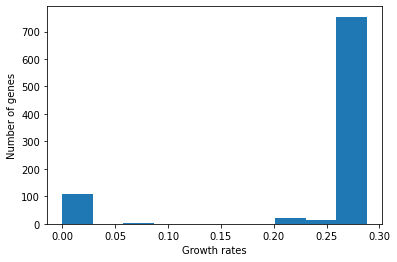

In [63]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(genes_ids)
y = np.array(grow_rates)

plt.hist(y)
plt.xlabel('Growth rates')
plt.ylabel('Number of genes')
#plt.show()
plt.savefig("distribution.png", dpi=100, bbox_inches='tight',pad_inches=0)

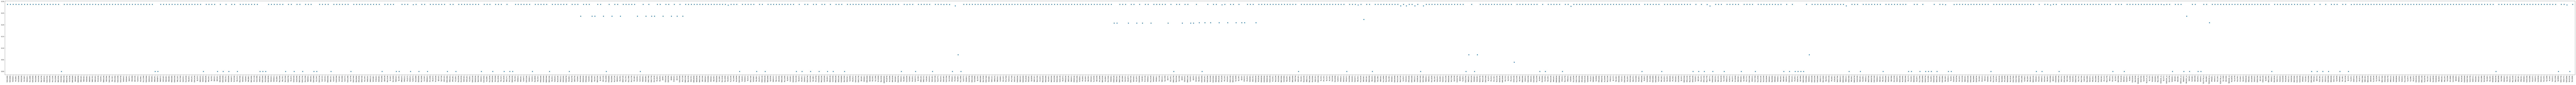

In [65]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(genes_ids)
y = np.array(grow_rates)

fig = plt.figure(figsize=(340, 10))
plt.scatter(x, y)
plt.margins(x=0.001) 
plt.xticks(rotation=90)
plt.show()
#plt.savefig("figure.png", dpi=100, bbox_inches='tight',pad_inches=0)

### Questions

1) Why the distribution of predicted mutant growth rates seems to be bimodal? 

2) Can you verify the consistency between gene and reactions knockouts results using a gene or a reaction of your choice?

3) Can you verify essentiality of your gene of choice from the previous excercise using relevant databases (e.g. KEGG and the SGD)?

4) Do you expect these results to change if we change the medium where we are growing our yeast model? 

### solution question 2

In [27]:
#type your code here, results in the html

In [28]:
#type your code here, results in the html

### solution question 3
When we look for YJL167W in the Saccharomyces genome database --> <a href="https://www.yeastgenome.org/locus/S000003703"> HERE </a>, we find out that YJL167W is an essential gene

### solution question 4
Yes, we will go deeper in this in the next notebook :)